<a href="https://colab.research.google.com/github/sachinagnihotri/Natural-Language-Processing/blob/main/Sentiment_Analysis_ANN%2C_CNN_vs_RNN_vs_LSTM_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#With Early Stopping

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense, Conv1D, GlobalMaxPooling1D, SimpleRNN, LSTM
from tensorflow.keras.callbacks import EarlyStopping
import random
import warnings
warnings.filterwarnings('ignore')


# Reproducibility

seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)
tf.keras.utils.set_random_seed(seed)
from tensorflow.keras import backend as K
K.clear_session()


# Parameters

max_words = 40000    # top 40k frequent words
max_len = 200        # pad/truncate reviews to 200 tokens
embedding_dim = 200  # embedding vector size


# Load IMDB dataset

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_words)
x_full = np.concatenate((x_train, x_test), axis=0)
y_full = np.concatenate((y_train, y_test), axis=0)
x_full = pad_sequences(x_full, maxlen=max_len)

# Split validation data
val_size = 10000
x_val = x_full[:val_size]
y_val = y_full[:val_size]
x_train_full = x_full[val_size:]
y_train_full = y_full[val_size:]

print(f"Training samples: {len(x_train_full)}, Validation samples: {len(x_val)}")


# Common EarlyStopping callback

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Training samples: 40000, Validation samples: 10000


In [ ]:
import matplotlib.pyplot as plt

def plot_learning_curves(histories, model_names):
    plt.figure(figsize=(14, 6))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    for history, name in zip(histories, model_names):
        plt.plot(history.history['accuracy'], label=f'{name} Train')
        plt.plot(history.history['val_accuracy'], linestyle='--', label=f'{name} Val')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Plot Loss
    plt.subplot(1, 2, 2)
    for history, name in zip(histories, model_names):
        plt.plot(history.history['loss'], label=f'{name} Train')
        plt.plot(history.history['val_loss'], linestyle='--', label=f'{name} Val')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


In [ ]:
# Feedforward NN (ANN)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

ffnn = Sequential([
    Embedding(max_words, embedding_dim, input_length=max_len),
    Flatten(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
ffnn.compile(optimizer = optimizer, loss='binary_crossentropy', metrics=['accuracy'])

print("\nTraining Feedforward NN (ANN)...")
history_ffnn = ffnn.fit(
    x_train_full, y_train_full,
    epochs=50, batch_size=128,
    validation_data=(x_val, y_val),
    callbacks=[early_stop],
    verbose=2
)
ffnn_acc = ffnn.evaluate(x_val, y_val, verbose=0)[1]
print("\nFeedforward NN Validation Accuracy:", round(ffnn_acc, 4))


Training Feedforward NN (ANN)...
Epoch 1/50
313/313 - 9s - 28ms/step - accuracy: 0.5179 - loss: 0.6922 - val_accuracy: 0.5306 - val_loss: 0.6911
Epoch 2/50
313/313 - 2s - 6ms/step - accuracy: 0.5584 - loss: 0.6883 - val_accuracy: 0.5599 - val_loss: 0.6884
Epoch 3/50
313/313 - 2s - 6ms/step - accuracy: 0.6052 - loss: 0.6829 - val_accuracy: 0.6011 - val_loss: 0.6836
Epoch 4/50
313/313 - 2s - 7ms/step - accuracy: 0.6550 - loss: 0.6737 - val_accuracy: 0.6530 - val_loss: 0.6750
Epoch 5/50
313/313 - 2s - 7ms/step - accuracy: 0.7012 - loss: 0.6595 - val_accuracy: 0.6940 - val_loss: 0.6598
Epoch 6/50
313/313 - 2s - 6ms/step - accuracy: 0.7420 - loss: 0.6362 - val_accuracy: 0.7272 - val_loss: 0.6354
Epoch 7/50
313/313 - 2s - 6ms/step - accuracy: 0.7713 - loss: 0.6031 - val_accuracy: 0.7548 - val_loss: 0.6020
Epoch 8/50
313/313 - 2s - 6ms/step - accuracy: 0.7957 - loss: 0.5621 - val_accuracy: 0.7767 - val_loss: 0.5633
Epoch 9/50
313/313 - 2s - 6ms/step - accuracy: 0.8116 - loss: 0.5200 - val_ac

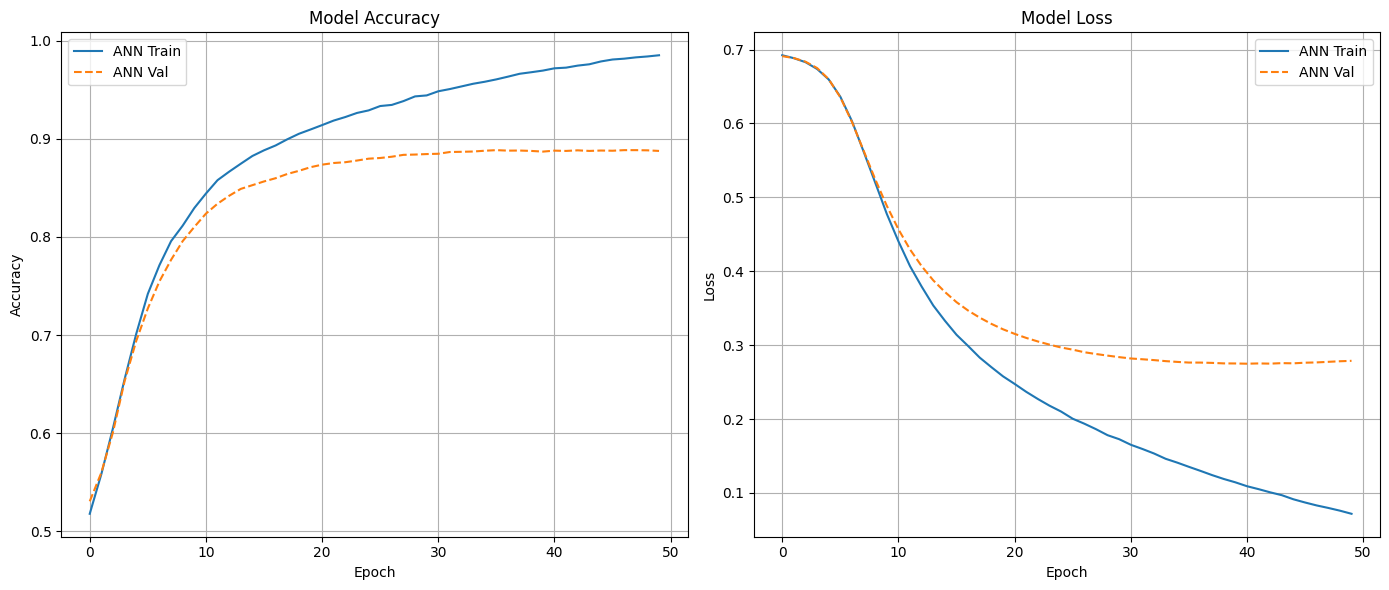

In [ ]:
plot_learning_curves(
    [history_ffnn],
    ['ANN']
)

In [ ]:
# CNN Model
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

cnn = Sequential([
    Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len),
    Conv1D(filters=256, kernel_size=2, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.00005)
cnn.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
print("\nTraining CNN...")
history_cnn = cnn.fit(
    x_train_full, y_train_full,
    epochs=50, batch_size=128,
    validation_data=(x_val, y_val),
    callbacks=[early_stop],
    verbose=2
)
cnn_acc = cnn.evaluate(x_val, y_val, verbose=0)[1]
print("\nCNN Validation Accuracy:", round(cnn_acc, 4))


Training CNN...
Epoch 1/50
313/313 - 23s - 73ms/step - accuracy: 0.6000 - loss: 0.6890 - val_accuracy: 0.6725 - val_loss: 0.6828
Epoch 2/50
313/313 - 7s - 23ms/step - accuracy: 0.6773 - loss: 0.6670 - val_accuracy: 0.6953 - val_loss: 0.6464
Epoch 3/50
313/313 - 6s - 18ms/step - accuracy: 0.7206 - loss: 0.6138 - val_accuracy: 0.7388 - val_loss: 0.5884
Epoch 4/50
313/313 - 6s - 18ms/step - accuracy: 0.7484 - loss: 0.5589 - val_accuracy: 0.7528 - val_loss: 0.5366
Epoch 5/50
313/313 - 6s - 19ms/step - accuracy: 0.7678 - loss: 0.5073 - val_accuracy: 0.7762 - val_loss: 0.4869
Epoch 6/50
313/313 - 6s - 20ms/step - accuracy: 0.7925 - loss: 0.4593 - val_accuracy: 0.8004 - val_loss: 0.4430
Epoch 7/50
313/313 - 6s - 18ms/step - accuracy: 0.8146 - loss: 0.4168 - val_accuracy: 0.8184 - val_loss: 0.4072
Epoch 8/50
313/313 - 5s - 16ms/step - accuracy: 0.8320 - loss: 0.3834 - val_accuracy: 0.8305 - val_loss: 0.3814
Epoch 9/50
313/313 - 5s - 15ms/step - accuracy: 0.8432 - loss: 0.3579 - val_accuracy: 

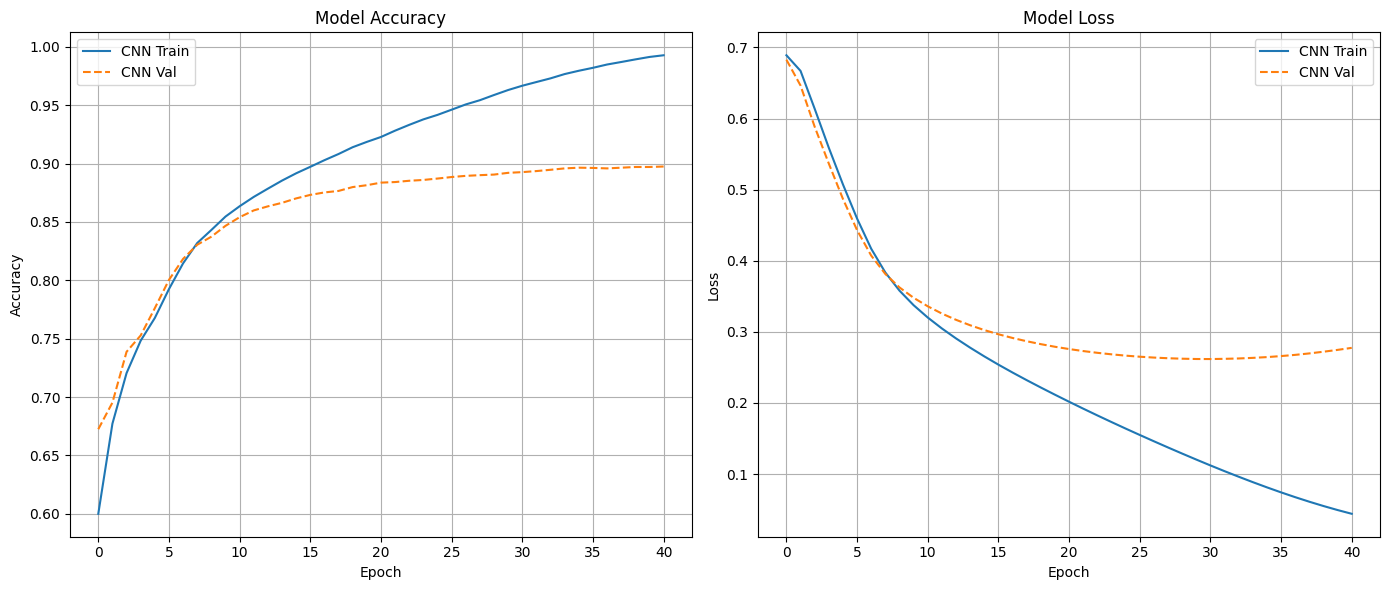

In [ ]:
plot_learning_curves(
    [history_cnn],
    ['CNN']
)

In [ ]:
# Simple RNN Model

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)


rnn = Sequential([
    Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len),
    SimpleRNN(256, activation='tanh'),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.00001)

rnn.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
print("\nTraining Simple RNN...")
history_rnn = rnn.fit(
    x_train_full, y_train_full,
    epochs=50, batch_size=32,
    validation_data=(x_val, y_val),
    callbacks=[early_stop],
    verbose=2
)
rnn_acc = rnn.evaluate(x_val, y_val, verbose=0)[1]
print("\nSimple RNN Validation Accuracy:", round(rnn_acc, 4))


Training Simple RNN...
Epoch 1/50
1250/1250 - 41s - 32ms/step - accuracy: 0.5616 - loss: 0.6761 - val_accuracy: 0.6188 - val_loss: 0.6460
Epoch 2/50
1250/1250 - 31s - 25ms/step - accuracy: 0.7414 - loss: 0.5336 - val_accuracy: 0.7821 - val_loss: 0.4775
Epoch 3/50
1250/1250 - 41s - 33ms/step - accuracy: 0.8197 - loss: 0.4130 - val_accuracy: 0.8318 - val_loss: 0.3880
Epoch 4/50
1250/1250 - 31s - 25ms/step - accuracy: 0.8531 - loss: 0.3509 - val_accuracy: 0.8480 - val_loss: 0.3491
Epoch 5/50
1250/1250 - 31s - 25ms/step - accuracy: 0.8728 - loss: 0.3131 - val_accuracy: 0.8595 - val_loss: 0.3292
Epoch 6/50
1250/1250 - 31s - 24ms/step - accuracy: 0.8859 - loss: 0.2865 - val_accuracy: 0.8661 - val_loss: 0.3145
Epoch 7/50
1250/1250 - 30s - 24ms/step - accuracy: 0.8952 - loss: 0.2664 - val_accuracy: 0.8717 - val_loss: 0.3043
Epoch 8/50
1250/1250 - 30s - 24ms/step - accuracy: 0.9031 - loss: 0.2501 - val_accuracy: 0.8746 - val_loss: 0.2977
Epoch 9/50
1250/1250 - 30s - 24ms/step - accuracy: 0.908

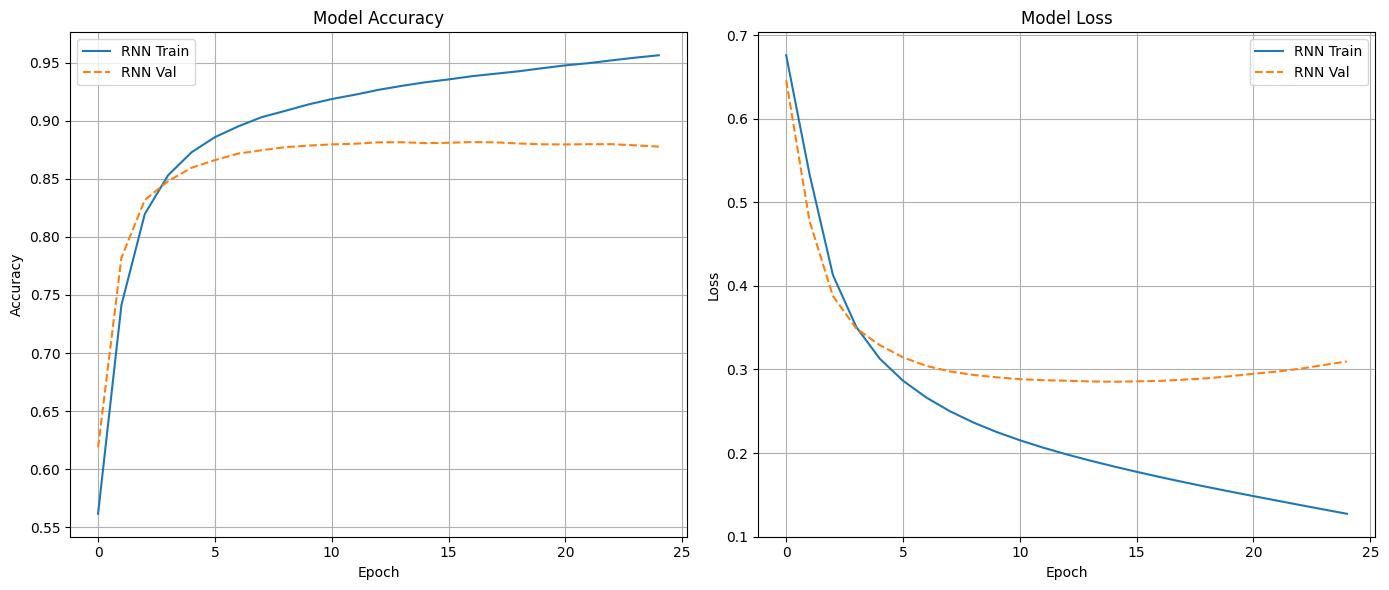

In [ ]:
plot_learning_curves(
    [history_rnn],
    ['RNN']
)

In [ ]:
# LSTM Model

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

lstm = Sequential([
    Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len),
    LSTM(256, activation='tanh'),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.00001)
lstm.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
print("\nTraining LSTM...")

history_lstm = lstm.fit(
    x_train_full, y_train_full,
    epochs=50, batch_size=32,
    validation_data=(x_val, y_val),
    callbacks=[early_stop],
    verbose=2
)
lstm_acc = lstm.evaluate(x_val, y_val, verbose=0)[1]
print("\nLSTM Validation Accuracy:", round(lstm_acc, 4))



Training LSTM...
Epoch 1/50
1250/1250 - 25s - 20ms/step - accuracy: 0.5212 - loss: 0.6929 - val_accuracy: 0.5583 - val_loss: 0.6925
Epoch 2/50
1250/1250 - 21s - 17ms/step - accuracy: 0.5663 - loss: 0.6920 - val_accuracy: 0.5891 - val_loss: 0.6911
Epoch 3/50
1250/1250 - 21s - 17ms/step - accuracy: 0.5997 - loss: 0.6898 - val_accuracy: 0.6173 - val_loss: 0.6877
Epoch 4/50
1250/1250 - 21s - 17ms/step - accuracy: 0.6458 - loss: 0.6717 - val_accuracy: 0.6634 - val_loss: 0.6110
Epoch 5/50
1250/1250 - 21s - 17ms/step - accuracy: 0.7264 - loss: 0.5509 - val_accuracy: 0.7554 - val_loss: 0.5107
Epoch 6/50
1250/1250 - 41s - 33ms/step - accuracy: 0.7955 - loss: 0.4556 - val_accuracy: 0.8088 - val_loss: 0.4321
Epoch 7/50
1250/1250 - 21s - 17ms/step - accuracy: 0.8377 - loss: 0.3830 - val_accuracy: 0.8335 - val_loss: 0.3792
Epoch 8/50
1250/1250 - 21s - 17ms/step - accuracy: 0.8633 - loss: 0.3304 - val_accuracy: 0.8554 - val_loss: 0.3404
Epoch 9/50
1250/1250 - 21s - 17ms/step - accuracy: 0.8773 - lo

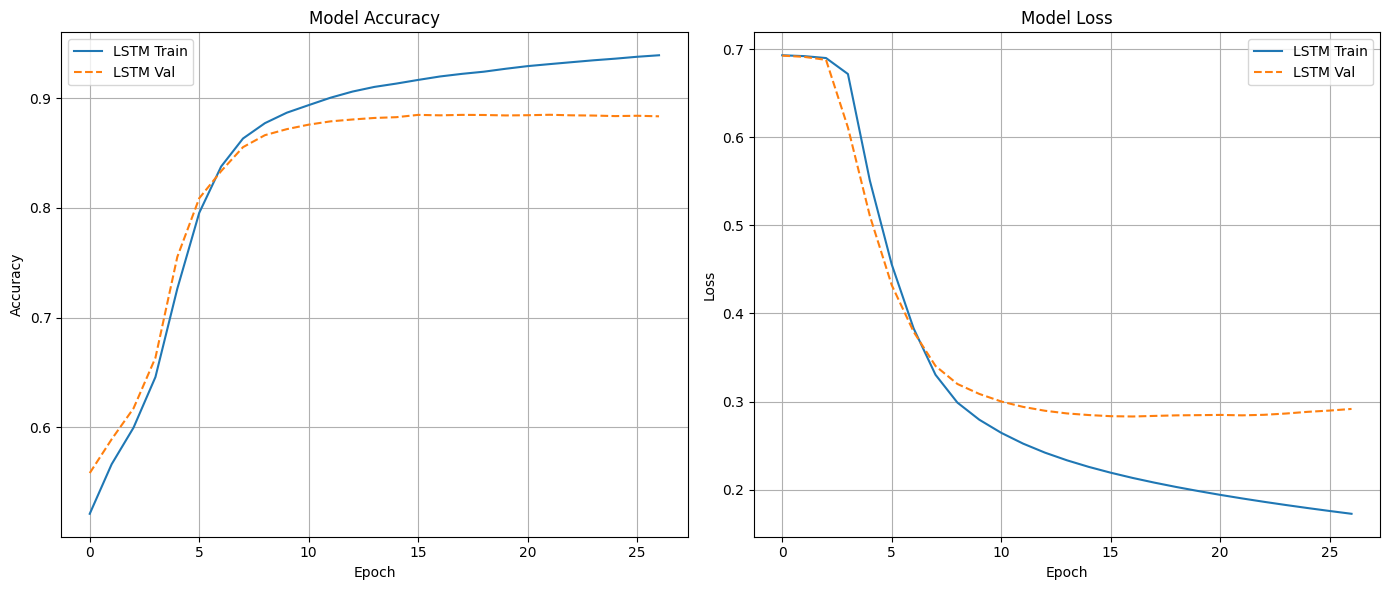

In [ ]:
plot_learning_curves(
    [history_lstm],
    ['LSTM']
)

In [ ]:
import numpy as np


# Get predictions for validation set

ffnn_preds = (ffnn.predict(x_val, verbose=0) > 0.5).astype(int).flatten()
cnn_preds  = (cnn.predict(x_val, verbose=0) > 0.5).astype(int).flatten()
rnn_preds  = (rnn.predict(x_val, verbose=0) > 0.5).astype(int).flatten()
lstm_preds = (lstm.predict(x_val, verbose=0) > 0.5).astype(int).flatten()



# Map integer index back to word
word_index = imdb.get_word_index()
index_word = {v + 3: k for k, v in word_index.items()}
index_word[0] = "<PAD>"
index_word[1] = "<START>"
index_word[2] = "<UNK>"
index_word[3] = "<UNUSED>"

def decode_review(sequence):
    """Convert integer sequence back to words"""
    return ' '.join([index_word.get(i, '?') for i in sequence if i != 0])


# Function to print samples

def print_samples(x, y_true, y_pred, model_name, n_samples=10):
    correct_idx = np.where(y_true == y_pred)[0]
    incorrect_idx = np.where(y_true != y_pred)[0]

    print(f"\n--- {model_name} Correctly Predicted Samples ---")
    for i in correct_idx[:n_samples]:
        print(f"\nTrue: {y_true[i]}, Pred: {y_pred[i]}")
        print("Review:", decode_review(x[i]))

    print(f"\n--- {model_name} Incorrectly Predicted Samples ---")
    for i in incorrect_idx[:n_samples]:
        print(f"\nTrue: {y_true[i]}, Pred: {y_pred[i]}")
        print("Review:", decode_review(x[i]))


1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
import numpy as np
import random

# Combine all predictions in one dictionary
model_preds = {
    "FFNN": ffnn_preds,
    "CNN": cnn_preds,
    "RNN": rnn_preds,
    "LSTM": lstm_preds
}

def compare_all_models(x, y_true, model_preds, n_samples=10):
    """
    Compare predictions from multiple models for the same samples.
    """
    sample_indices = random.sample(range(len(x)), n_samples)

    for idx in sample_indices:
        print("="*120)
        print(f"Review #{idx}")
        print(f"True Label: {'Positive' if y_true[idx]==1 else 'Negative'}\n")

        review_text = decode_review(x[idx])
        print("Review Text:")
        print(review_text[:700] + "..." if len(review_text) > 700 else review_text)
        print("-"*120)

        print("Model Predictions:")
        for name, preds in model_preds.items():
            pred_label = "Positive" if preds[idx] == 1 else "Negative"
            correct = (preds[idx] == y_true[idx])
            mark = "[TRUE]" if correct else "[WRONG]"
            print(f"{name:8s}: {pred_label:<8s} {mark}")
        print("="*120 + "\n")

# Run comparison
compare_all_models(x_val, y_val, model_preds, n_samples=10)


Review #3811
True Label: Positive

Review Text:
<START> it was in 1988 when i saw the ronnie and nancy show for the first time on austrian television at that time i was already a very big fan of spitting image since when it won the bronze rose of the <UNK> film festival in 1986 of course i recorded every show on tape and watched it again and again especially the ronnie and nancy show i remember that scene when ronnie stood in front of a painting of abraham lincoln thinking it was a mirror and said to himself i need a shave or most amusing of all when he played ball with his dog but vice versa br br it's such a shame that spitting image seems to fall into oblivion it was one of the most fantastic and most intelligent made tv shows ever com...
------------------------------------------------------------------------------------------------------------------------
Model Predictions:
FFNN    : Positive [TRUE]
CNN     : Positive [TRUE]
RNN     : Positive [TRUE]
LSTM    : Positive [TRUE]

Rev